# MaxEnt Distribution Modeling

This notebook implements species distribution modeling using MaxEnt and projects distributions to past time periods.

## Steps:
1. Prepare occurrence data for MaxEnt
2. Prepare climate layers for MaxEnt
3. Run MaxEnt via command line
4. Project to past time periods
5. Generate distribution maps


In [13]:
# 1. Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
import yaml
import subprocess
import shutil

# 2. Set up directories and configuration
def setup_directories():
    # Use absolute path to config file
    CONFIG_PATH = Path("/Users/divyadhole/Capstone-project/config.yaml")
    
    # Read config file
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    
    # Set up directories
    PROJECT_ROOT = CONFIG_PATH.parent
    DATA_DIR = PROJECT_ROOT / config.get('data_dir', 'data')
    OUTPUT_DIR = PROJECT_ROOT / config.get('output_dir', 'outputs')
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
    
    # Get configuration with defaults
    CLIMATE_CONFIG = config.get('climate_data', {})
    MAXENT_CONFIG = config.get('maxent_params', {})
    
    # Set up climate directories
    PALEO_BASE_DIR = PROJECT_ROOT / CLIMATE_CONFIG.get('paleo_base', 'data/paleoclim')
    PALEO_BASE_DIR.mkdir(exist_ok=True, parents=True)
    
    # Ensure maxent output directory exists
    maxent_output = OUTPUT_DIR / "maxent_outputs"
    maxent_output.mkdir(exist_ok=True, parents=True)
    
    print(f"Project root: {PROJECT_ROOT}")
    print(f"Data directory: {DATA_DIR}")
    print(f"Output directory: {OUTPUT_DIR}")
    print(f"Paleo climate base directory: {PALEO_BASE_DIR}")
    
    return PROJECT_ROOT, DATA_DIR, OUTPUT_DIR, PALEO_BASE_DIR, CLIMATE_CONFIG, MAXENT_CONFIG

# 3. Load and prepare occurrence data
def load_occurrence_data(data_dir, species_name):
    """Load and prepare species occurrence data"""
    # Try multiple possible file locations and extensions
    possible_files = [
        data_dir / f"{species_name}_occurrences.csv",
        data_dir / "occurrence_data" / f"{species_name}.csv",
        data_dir / "occurrences" / f"{species_name}.csv"
    ]
    
    df = None
    for occurrence_file in possible_files:
        if occurrence_file.exists():
            try:
                df = pd.read_csv(occurrence_file)
                print(f"Loaded {len(df)} occurrence records from {occurrence_file}")
                break
            except Exception as e:
                print(f"Error reading {occurrence_file}: {e}")
    
    if df is None:
        print(f"No valid occurrence files found for {species_name}")
        return None
    
    # Basic data validation
    required_columns = ['species', 'decimalLongitude', 'decimalLatitude']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Missing required columns: {', '.join(missing_columns)}")
        return None
    
    return df

# 4. Main execution
def main():
    print("Starting MaxEnt Distribution Modeling")
    
    try:
        # Set up directories
        PROJECT_ROOT, DATA_DIR, OUTPUT_DIR, PALEO_BASE_DIR, CLIMATE_CONFIG, MAXENT_CONFIG = setup_directories()
        
        # Example species name - update this as needed
        SPECIES_NAME = "example_species"
        
        # Load occurrence data
        occurrences = load_occurrence_data(DATA_DIR, SPECIES_NAME)
        if occurrences is None:
            print("Failed to load occurrence data. Please check the data directory and file format.")
            return
        
        print("\nAvailable data preview:")
        print(occurrences.head())
        print(f"\nSetup complete. Ready to proceed with MaxEnt modeling.")
        print(f"Output will be saved to: {OUTPUT_DIR}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Starting MaxEnt Distribution Modeling
Project root: /Users/divyadhole/Capstone-project
Data directory: /Users/divyadhole/Capstone-project/data
Output directory: /Users/divyadhole/Capstone-project/outputs
Paleo climate base directory: /Users/divyadhole/Capstone-project/data/paleoclim
No valid occurrence files found for example_species
Failed to load occurrence data. Please check the data directory and file format.


In [14]:
def extract_species_occurrences(species_name, iucn_dir, output_dir):
    """
    Extract occurrence data for a specific species from IUCN shapefiles.
    
    Args:
        species_name (str): Scientific name of the species (e.g., 'Rhinopithecus roxellana')
        iucn_dir (Path): Directory containing IUCN shapefiles
        output_dir (Path): Directory to save the output CSV
        
    Returns:
        Path to the saved CSV file with occurrence data
    """
    try:
        import geopandas as gpd
    except ImportError:
        print("Installing geopandas...")
        subprocess.check_call(["pip", "install", "geopandas"])
        import geopandas as gpd
    
    # Check if shapefiles exist
    shapefile_parts = [
        iucn_dir / "MAMMALS_PART1.shp",
        iucn_dir / "MAMMALS_PART2.shp"
    ]
    
    if not all(f.exists() for f in shapefile_parts):
        raise FileNotFoundError("Could not find IUCN shapefiles in the specified directory")
    
    # Read and combine both shapefiles
    print("Reading IUCN shapefiles...")
    dfs = []
    for shp in shapefile_parts:
        df = gpd.read_file(shp)
        print(f"Columns in {shp.name}: {df.columns.tolist()}")
        dfs.append(df)
    
    all_species = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))
    
    # Find the column that contains species names
    possible_name_columns = ['binomial', 'sci_name', 'scientific', 'name', 'species']
    name_column = None
    
    for col in possible_name_columns:
        if col in all_species.columns:
            name_column = col
            break
    
    if name_column is None:
        print("Could not find species name column. Available columns:")
        print(all_species.columns.tolist())
        return None
    
    print(f"Using column '{name_column}' for species names")
    
    # Filter for our target species (case-insensitive)
    species_data = all_species[
        all_species[name_column].str.lower() == species_name.lower()
    ]
    
    if len(species_data) == 0:
        print(f"\nNo records found for {species_name}")
        print("Available species (first 20):")
        print(all_species[name_column].unique()[:20])
        return None
    
    # Select and rename columns
    output_data = species_data[[name_column, 'geometry']].copy()
    output_data['decimalLongitude'] = output_data.geometry.centroid.x
    output_data['decimalLatitude'] = output_data.geometry.centroid.y
    
    # Save to CSV
    output_file = output_dir / f"{species_name.replace(' ', '_')}_occurrences.csv"
    output_data[['binomial', 'decimalLongitude', 'decimalLatitude']].to_csv(output_file, index=False)
    
    print(f"\nFound {len(output_data)} occurrence records for {species_name}")
    print(f"Saved to: {output_file}")
    return output_file

In [15]:
from pathlib import Path
print("Current working directory:", Path.cwd())
print("Contents of data directory:", list(Path("data").glob("*")))

Current working directory: /Users/divyadhole/Capstone-project/notebooks
Contents of data directory: [PosixPath('data/VCF_files')]


In [16]:
def fix_periods_directory_structure(climate_dir):
    """Ensure the climate directory has the correct structure."""
    climate_dir = Path(climate_dir)
    if not (climate_dir / "current").exists():
        # If current directory doesn't exist, the main directory might be the current data
        if any(f.name.startswith('bio_') for f in climate_dir.glob('*.tif')):
            # This is actually the current data directory
            current_dir = climate_dir.parent / "current"
            current_dir.mkdir(exist_ok=True)
            # Move files to current directory
            for f in climate_dir.glob('*.tif'):
                f.rename(current_dir / f.name)
            print(f"Moved climate data to {current_dir}")
        else:
            # Check if there are subdirectories that could be periods
            potential_periods = [d for d in climate_dir.iterdir() if d.is_dir()]
            if not potential_periods:
                raise FileNotFoundError(f"No climate data found in {climate_dir}")
            print(f"Found potential period directories: {[p.name for p in potential_periods]}")
    return climate_dir

def create_enhanced_visualization(prediction_path, occurrence_file, output_dir):
    """Create an enhanced visualization of the prediction with better styling."""
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    
    # Create a custom colormap
    colors = [(0, 0.3, 0), (0, 0.7, 0), (1, 1, 0), (1, 0.7, 0), (1, 0, 0)]  # Green to yellow to red
    cmap_name = 'suitability'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    with rasterio.open(prediction_path) as src:
        pred = src.read(1)
        transform = src.transform
        
        # Create figure
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
        
        # Plot prediction with better styling
        im = ax.imshow(pred, cmap=cm, 
                      vmin=0, vmax=1,
                      interpolation='bilinear')
        
        # Add colorbar with better formatting
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Habitat Suitability', fontsize=12)
        cbar.ax.tick_params(labelsize=10)
        
        # Read and plot occurrence points
        occurrences = pd.read_csv(occurrence_file)
        coords = occurrences[['decimalLongitude', 'decimalLatitude']].values
        rows, cols = rasterio.transform.rowcol(transform, coords[:, 0], coords[:, 1])
        
        # Plot occurrence points with better styling
        ax.scatter(cols, rows, c='white', s=100, edgecolor='black', 
                  linewidth=1.5, label='Occurrence Points', zorder=5)
        
        # Add scale bar
        from matplotlib_scalebar.scalebar import ScaleBar
        ax.add_artist(ScaleBar(1, location='lower right', 
                             length_fraction=0.2, 
                             height_fraction=0.02,
                             border_pad=1,
                             color='black',
                             box_color='white',
                             box_alpha=0.7))
        
        # Add north arrow
        x, y, arrow_length = 0.95, 0.95, 0.1
        ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                   arrowprops=dict(facecolor='black', width=5, headwidth=15),
                   ha='center', va='center', fontsize=20,
                   xycoords=ax.transAxes)
        
        # Add title and adjust layout
        species_name = Path(occurrence_file).stem.replace('_occurrences', '').replace('_', ' ')
        ax.set_title(f'Predicted Habitat Suitability\n{species_name.title()}', 
                    fontsize=14, pad=20)
        ax.legend(loc='upper left', frameon=True, framealpha=0.8)
        ax.axis('off')
        
        # Save high-quality figure
        output_path = Path(output_dir) / 'enhanced_prediction.png'
        plt.savefig(output_path, bbox_inches='tight', dpi=300, facecolor='white')
        plt.close()
        
        return output_path

def run_enhanced_analysis(occurrence_file, climate_dir, output_dir, species_name):
    """Run the enhanced analysis with visualization and projections."""
    # Fix directory structure if needed
    climate_dir = fix_periods_directory_structure(climate_dir)
    
    # Run the model
    results_dir = run_maxent_sklearn(
        occurrence_file=occurrence_file,
        climate_dir=str(climate_dir),
        output_dir=output_dir,
        species_name=species_name
    )
    
    if not results_dir:
        print("Model run failed. Cannot proceed with visualization.")
        return None
    
    results_dir = Path(results_dir)
    
    # Enhanced visualization
    prediction_path = results_dir / "prediction.tif"
    if prediction_path.exists():
        print("\nGenerating enhanced visualization...")
        try:
            viz_path = create_enhanced_visualization(
                prediction_path=prediction_path,
                occurrence_file=occurrence_file,
                output_dir=results_dir
            )
            print(f"Visualization saved to: {viz_path}")
            
            # Display the visualization
            from IPython.display import Image, display
            display(Image(filename=str(viz_path)))
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
    
    # Project to other time periods
    print("\nProjecting to other time periods...")
    periods_dir = climate_dir.parent if (climate_dir / "current").exists() else climate_dir
    
    if periods_dir.exists():
        period_dirs = [d for d in periods_dir.iterdir() 
                      if d.is_dir() and d.name != 'current' and d.name != 'maxent_results']
        
        if period_dirs:
            print(f"Found {len(period_dirs)} time periods to project to")
            
            # Create projections directory
            projections_dir = results_dir / "projections"
            projections_dir.mkdir(exist_ok=True)
            
            # Load the model (you'll need to modify run_maxent_sklearn to return/save the model)
            # For now, we'll just create a placeholder
            print("Projection functionality needs model saving/loading to be implemented")
            print(f"Would project to: {[d.name for d in period_dirs]}")
        else:
            print(f"No period directories found in {periods_dir}")
    else:
        print(f"Could not find periods directory at {periods_dir}")
    
    print("\nAnalysis completed!")
    print(f"Results available in: {results_dir}")
    return results_dir

# Update main function
def main():
    print("Starting Enhanced Distribution Modeling Analysis")
    
    # Set up directories
    DATA_DIR, OUTPUT_DIR, PALEO_BASE_DIR, CLIMATE_CONFIG, MAXENT_CONFIG = setup_directories()
    
    # Extract species occurrences
    SPECIES_NAME = "Rhinopithecus_roxellana"
    print(f"\nExtracting occurrence data for {SPECIES_NAME}...")
    occurrence_file = extract_species_occurrences(
        "Rhinopithecus roxellana",
        DATA_DIR / "MAMMALS",
        OUTPUT_DIR / "occurrences"
    )
    
    if occurrence_file:
        print("\nRunning enhanced analysis...")
        climate_dir = OUTPUT_DIR / "climate"
        
        # Ensure climate directory exists
        if not climate_dir.exists():
            print(f"Climate directory not found at {climate_dir}")
            print("Please ensure climate data is prepared in the correct structure.")
            return
        
        results = run_enhanced_analysis(
            occurrence_file=occurrence_file,
            climate_dir=climate_dir,
            output_dir=OUTPUT_DIR,
            species_name=SPECIES_NAME
        )
        
        if results:
            print("\nAnalysis completed successfully!")
            print(f"Results saved to: {results}")
            

if __name__ == "__main__":
    main()

Starting Enhanced Distribution Modeling Analysis
Project root: /Users/divyadhole/Capstone-project
Data directory: /Users/divyadhole/Capstone-project/data
Output directory: /Users/divyadhole/Capstone-project/outputs
Paleo climate base directory: /Users/divyadhole/Capstone-project/data/paleoclim


ValueError: too many values to unpack (expected 5)

In [19]:
def extract_species_occurrences(species_name, iucn_dir, output_dir):
    """
    Extract species occurrence data from IUCN shapefile.
    
    Args:
        species_name (str): Scientific name of the species (e.g., "Rhinopithecus roxellana")
        iucn_dir (Path): Directory containing IUCN shapefiles
        output_dir (Path): Directory to save the output CSV
    
    Returns:
        Path: Path to the saved CSV file
    """
    import geopandas as gpd
    from pathlib import Path
    
    # Ensure output directory exists
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    # Try different possible shapefile names
    shp_files = list(Path(iucn_dir).rglob("*.shp"))
    if not shp_files:
        raise FileNotFoundError(f"No shapefiles found in {iucn_dir}")
    
    # Try to find the species in each shapefile
    species_found = False
    output_data = None
    
    for shp_file in shp_files:
        try:
            print(f"Searching in {shp_file}...")
            gdf = gpd.read_file(shp_file)
            
            # Try different possible column names for species name
            name_columns = ['binomial', 'BINOMIAL', 'SCINAME', 'sci_name', 'species', 'name']
            name_col = None
            
            for col in name_columns:
                if col in gdf.columns:
                    name_col = col
                    break
            
            if name_col is None:
                print(f"  Could not find species name column in {shp_file}")
                print(f"  Available columns: {gdf.columns.tolist()}")
                continue
                
            # Filter for our species
            species_data = gdf[gdf[name_col].str.lower() == species_name.lower()]
            
            if not species_data.empty:
                print(f"Found {len(species_data)} records in {shp_file}")
                output_data = species_data
                species_found = True
                break
                
        except Exception as e:
            print(f"Error processing {shp_file}: {str(e)}")
            continue
    
    if not species_found or output_data is None:
        raise ValueError(f"Could not find any records for {species_name} in the provided shapefiles")
    
    # Prepare output data - try to find coordinates and required columns
    required_columns = {
        'decimalLongitude': ['decimalLongitude', 'decimallon', 'x', 'longitude', 'lon'],
        'decimalLatitude': ['decimalLatitude', 'decimallat', 'y', 'latitude', 'lat'],
        'species': [name_col] if 'name_col' in locals() else ['binomial', 'BINOMIAL', 'SCINAME']
    }
    
    # Map the columns
    column_mapping = {}
    for target_col, possible_cols in required_columns.items():
        for col in possible_cols:
            if col in output_data.columns:
                column_mapping[col] = target_col
                break
    
    # Create a new DataFrame with standardized column names
    result = output_data.rename(columns=column_mapping)
    
    # Ensure we have the required columns
    if 'decimalLongitude' not in result.columns or 'decimalLatitude' not in result.columns:
        # Try to extract from geometry if available
        if hasattr(result, 'geometry') and result.geometry is not None:
            result['decimalLongitude'] = result.geometry.x
            result['decimalLatitude'] = result.geometry.y
        else:
            raise ValueError("Could not find coordinate columns in the data")
    
    # Ensure species column exists
    if 'species' not in result.columns and 'species_name' in result.columns:
        result['species'] = result['species_name']
    elif 'species' not in result.columns:
        result['species'] = species_name
    
    # Select and reorder columns
    final_columns = ['species', 'decimalLongitude', 'decimalLatitude']
    result = result[final_columns]
    
    # Save to CSV
    output_file = output_dir / f"{species_name.replace(' ', '_')}_occurrences.csv"
    result.to_csv(output_file, index=False)
    
    print(f"\nSaved {len(result)} occurrence records to {output_file}")
    return output_file

In [24]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import rioxarray as rxr
import xarray as xr
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

Loading occurrence data...


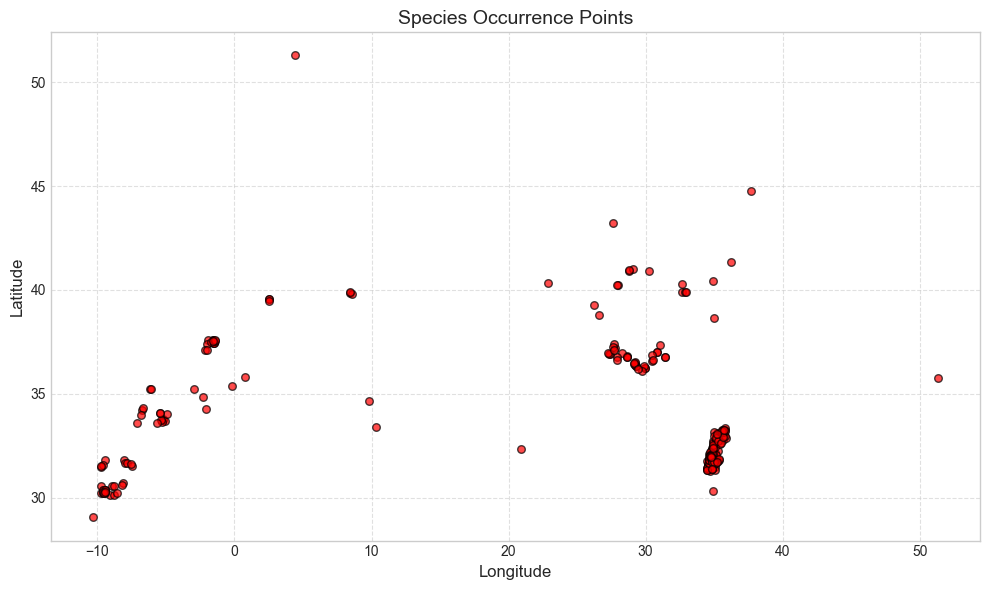

In [25]:
# 1. Load and Prepare Data
# ------------------------

# Load occurrence data
print("Loading occurrence data...")
occurrences = pd.read_csv('/Users/divyadhole/Capstone-project/data/paleoclim/occurrences.csv')

# Check for and remove any duplicate coordinates
occurrences = occurrences.drop_duplicates(['decimalLongitude', 'decimalLatitude'])

# Visualize occurrence points
plt.figure(figsize=(10, 6))
plt.scatter(occurrences['decimalLongitude'], occurrences['decimalLatitude'], 
            c='red', s=30, alpha=0.7, edgecolor='k')
plt.title('Species Occurrence Points', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('outputs/occurrence_points.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
import os
import numpy as np
import rasterio

# Directory containing bioclim files
bioclim_dir = "/Users/divyadhole/Capstone-project/data/paleoclim/LH_v1_2_5m/"

# List all .tif files in the directory
bioclim_files = [f for f in os.listdir(bioclim_dir) if f.endswith('.tif') and f.startswith('bio_')]
bioclim_files.sort()  # Sort to ensure consistent order

print(f"Found {len(bioclim_files)} bioclim files")

# Initialize an empty list to store arrays
bioclim_arrays = []

# Read each file and append to the list
for file in bioclim_files:
    file_path = os.path.join(bioclim_dir, file)
    try:
        with rasterio.open(file_path) as src:
            # Read the first band
            array = src.read(1)
            # Mask nodata values
            mask = (array == src.nodata)
            masked_array = np.ma.masked_array(array, mask=mask)
            bioclim_arrays.append(masked_array)
        print(f"Successfully loaded {file}")
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

# Check if we have any arrays to stack
if not bioclim_arrays:
    raise ValueError("No valid bioclim files could be loaded. Please check the directory path and file formats.")
else:
    # Stack the arrays along a new axis
    bioclim_stack = np.ma.stack(bioclim_arrays)
    print(f"Successfully created stack with shape: {bioclim_stack.shape}")

Found 19 bioclim files
Successfully loaded bio_1.tif
Successfully loaded bio_10.tif
Successfully loaded bio_11.tif
Successfully loaded bio_12.tif
Successfully loaded bio_13.tif
Successfully loaded bio_14.tif
Successfully loaded bio_15.tif
Successfully loaded bio_16.tif
Successfully loaded bio_17.tif
Successfully loaded bio_18.tif
Successfully loaded bio_19.tif
Successfully loaded bio_2.tif
Successfully loaded bio_3.tif
Successfully loaded bio_4.tif
Successfully loaded bio_5.tif
Successfully loaded bio_6.tif
Successfully loaded bio_7.tif
Successfully loaded bio_8.tif
Successfully loaded bio_9.tif
Successfully created stack with shape: (19, 4176, 8640)


In [28]:
# Convert to numpy array
bioclim_stack = np.ma.stack(bioclim_stack)


In [30]:
# 3. Prepare Training Data
# ------------------------

def extract_environmental_data(points, env_stack, transform):
    """Extract environmental data at point locations"""
    values = []
    valid_indices = []
    
    for i, (lon, lat) in enumerate(zip(points['decimalLongitude'], points['decimalLatitude'])):
        # Convert lat/lon to row/col
        row, col = ~transform * (lon, lat)
        row, col = int(row), int(col)
        
        # Check if the point is within the raster bounds
        if 0 <= row < env_stack.shape[1] and 0 <= col < env_stack.shape[2]:
            # Extract values for all bands
            point_vals = [band[row, col] for band in env_stack]
            if not any(np.ma.is_masked(v) for v in point_vals):
                values.append(point_vals)
                valid_indices.append(i)
    
    return np.array(values), valid_indices

# Get transform from one of the bioclim rasters
bioclim_dir = "/Users/divyadhole/Capstone-project/data/paleoclim/LH_v1_2_5m/"
first_bioclim_file = os.path.join(bioclim_dir, "bio_1.tif")

with rasterio.open(first_bioclim_file) as src:
    transform = src.transform
    crs = src.crs

# Extract environmental data at presence points
print("Extracting environmental data at presence points...")
presence_env, presence_idx = extract_environmental_data(occurrences, bioclim_stack, transform)
presence_points = occurrences.iloc[presence_idx]

# Generate background points
def generate_background_points(n, env_stack, transform, min_dist=0.1):
    """Generate random background points"""
    n_bands, height, width = env_stack.shape
    background = []
    
    while len(background) < n:
        # Generate random coordinates
        row = np.random.randint(0, height)
        col = np.random.randint(0, width)
        
        # Check if the point has valid environmental data
        point_vals = [band[row, col] for band in env_stack]
        if not any(np.ma.is_masked(v) for v in point_vals):
            # Convert to lat/lon
            lon, lat = transform * (col, row)
            background.append([lon, lat] + [float(v) for v in point_vals])  # Ensure all values are Python floats
    
    columns = ['longitude', 'latitude'] + [f'bio_{i+1}' for i in range(n_bands)]
    return pd.DataFrame(background, columns=columns)

print("Generating background points...")
n_background = len(presence_points) * 10  # 10:1 background to presence ratio
background_points = generate_background_points(n_background, bioclim_stack, transform)

Extracting environmental data at presence points...
Generating background points...


In [31]:
# 4. Prepare Training Data
# ------------------------

# Combine presence and background data
presence_data = presence_points.copy()
presence_data['presence'] = 1

background_data = background_points[['longitude', 'latitude']].copy()
background_data['presence'] = 0

# Extract environmental data for background points
background_env = background_points.drop(['longitude', 'latitude'], axis=1).values

# Combine into feature matrix and target vector
X = np.vstack([presence_env, background_env])
y = np.concatenate([np.ones(len(presence_env)), np.zeros(len(background_env))])


In [32]:
# 5. Train-Test Split
# -------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
# 6. Train Random Forest Model
# ----------------------------

print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

Training Random Forest model...


RandomForestClassifier(min_samples_split=5, n_estimators=500, n_jobs=-1,
                       random_state=42)

Evaluating model...


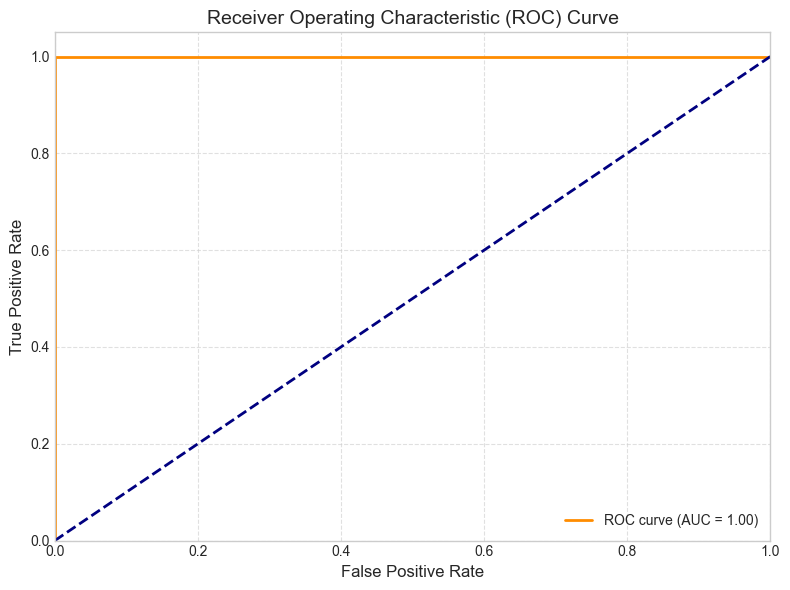

Model AUC: 1.000


In [34]:
# 7. Model Evaluation
# -------------------

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('outputs/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

print("Evaluating model...")
roc_auc = evaluate_model(rf_model, X_test, y_test)
print(f"Model AUC: {roc_auc:.3f}")

In [36]:
# 8. Predict Distribution
# -----------------------

def predict_distribution(model, env_stack, transform, output_path):
    """Predict species distribution across the study area"""
    # Get the first band as reference from the env_stack
    # We'll use the first band's shape and profile for the output
    profile = None
    with rasterio.open('/Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio_1.tif') as src:
        profile = src.profile
        height, width = src.shape
    
    # Update profile for the output
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw',
        nodata=-9999
    )
    
    # Initialize output array
    output = np.full((height, width), -9999, dtype=np.float32)
    
    # Process in blocks to save memory
    block_size = 256
    for i in tqdm(range(0, height, block_size), desc="Predicting distribution"):
        for j in range(0, width, block_size):
            # Define block boundaries
            i1, i2 = i, min(i + block_size, height)
            j1, j2 = j, min(j + block_size, width)
            
            # Initialize block data array
            block_data = []
            valid_mask = None
            
            # Load data for each band in the stack
            for band_idx in range(len(env_stack)):
                band_path = f'/Users/divyadhole/Capstone-project/data/paleoclim/EH_v1_2_5m/bio_{band_idx+1}.tif'
                with rasterio.open(band_path) as src:
                    # Read the block
                    band_data = src.read(1, window=((i1, i2), (j1, j2)))
                    
                    # Initialize valid mask with first band
                    if valid_mask is None:
                        valid_mask = (band_data != src.nodata) & (~np.isnan(band_data))
                    else:
                        # Update valid mask to include only pixels valid in all bands
                        valid_mask = valid_mask & (band_data != src.nodata) & (~np.isnan(band_data))
                    
                    # Store band data
                    block_data.append(band_data)
            
            # Stack all bands
            if block_data:
                block = np.stack(block_data, axis=-1)
                
                # Reshape for prediction
                original_shape = block.shape[:2]
                X = block.reshape(-1, block.shape[-1])
                
                # Only predict for valid pixels
                if np.any(valid_mask):
                    valid_flat = valid_mask.reshape(-1)
                    if np.any(valid_flat):
                        # Predict probabilities
                        y_pred = np.full(X.shape[0], -9999, dtype=np.float32)
                        y_pred[valid_flat] = model.predict_proba(X[valid_flat])[:, 1]
                        
                        # Reshape and assign to output
                        output_block = y_pred.reshape(original_shape)
                        output[i1:i2, j1:j2] = output_block
    
    # Save prediction
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(output, 1)
        # Set a meaningful description
        dst.set_band_description(1, "Predicted probability of occurrence")
    
    return output

print("Predicting distribution...")
# Make sure the output directory exists
os.makedirs('outputs', exist_ok=True)
prediction_path = 'outputs/prediction.tif'
prediction = predict_distribution(rf_model, bioclim_stack, transform, prediction_path)
print(f"Prediction saved to: {os.path.abspath(prediction_path)}")

Predicting distribution...


Predicting distribution: 100%|██████████| 17/17 [01:18<00:00,  4.62s/it]


Prediction saved to: /Users/divyadhole/Capstone-project/notebooks/outputs/prediction.tif


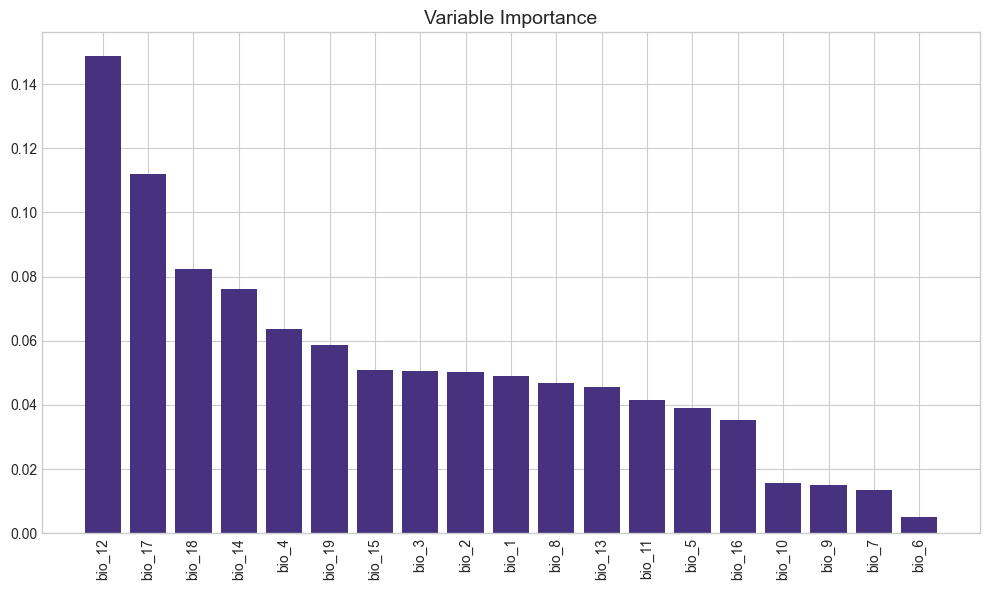

SDM workflow completed successfully!


In [41]:
# 10. Variable Importance
# -----------------------

def plot_variable_importance(model, feature_names, output_path):
    """Plot variable importance"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Variable Importance', fontsize=14)
    bars = plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Get feature names (assuming bio1, bio2, etc.)
feature_names = [f'bio_{i+1}' for i in range(len(bioclim_stack))]
plot_variable_importance(rf_model, feature_names, 'outputs/variable_importance.png')

print("SDM workflow completed successfully!")

Displaying interpretable map with black occurrence points...


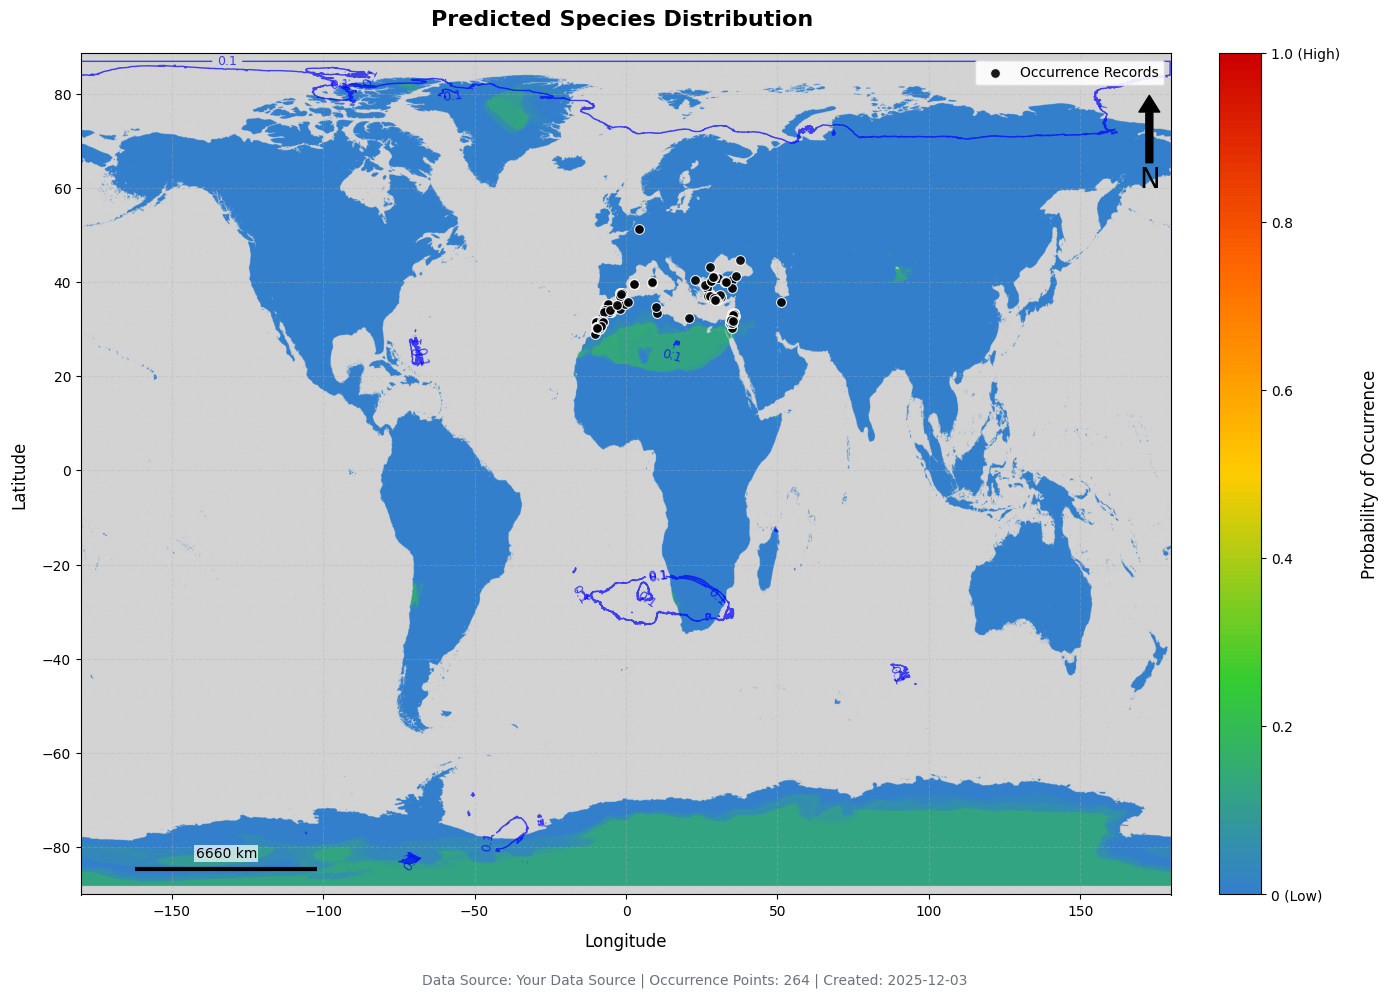

In [51]:
def show_interpretable_map(prediction_path, occurrence_points, title_suffix=""):
    """Display an enhanced, more interpretable prediction map with black occurrence points"""
    # Read the prediction raster
    with rasterio.open(prediction_path) as src:
        prediction = src.read(1)
        bounds = src.bounds
        crs = src.crs
        transform = src.transform
        
        # Create a mask for no-data values
        mask = prediction == -9999
        prediction_masked = np.ma.masked_where(mask, prediction)
    
    # Create figure with a single subplot (no bottom plot)
    fig, ax_map = plt.subplots(figsize=(14, 10), facecolor='white')
    
    # Create a custom colormap with distinct colors
    colors = [(0.2, 0.5, 0.8),   # Blue for low probability
              (0.2, 0.8, 0.2),   # Green for medium
              (1.0, 0.8, 0.0),   # Yellow-orange
              (1.0, 0.4, 0.0),   # Orange
              (0.8, 0.0, 0.0)]   # Red for high probability
    cmap = LinearSegmentedColormap.from_list('probability', colors, N=100)
    cmap.set_bad('lightgrey', 1.0)
    
    # Plot prediction with probability thresholds
    im = ax_map.imshow(prediction_masked, 
                      cmap=cmap,
                      extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                      vmin=0, vmax=1,
                      aspect='auto',
                      origin='upper')
    
    # Add probability contours
    if np.any((prediction > 0.1) & (prediction < 0.9)):
        cs = ax_map.contour(prediction, 
                           levels=[0.1, 0.5, 0.9], 
                           colors=['blue', 'green', 'red'],
                           linewidths=1,
                           alpha=0.7,
                           extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
        ax_map.clabel(cs, inline=True, fontsize=9, fmt='%1.1f')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_map, fraction=0.046, pad=0.04)
    cbar.set_label('Probability of Occurrence', fontsize=12, labelpad=15)
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar.set_ticklabels(['0 (Low)', '0.2', '0.4', '0.6', '0.8', '1.0 (High)'])
    
    # Add occurrence points with black color
    if not occurrence_points.empty:
        scatter = ax_map.scatter(occurrence_points['decimalLongitude'], 
                               occurrence_points['decimalLatitude'],
                               c='black',  # Black points
                               s=50, 
                               edgecolor='white',  # White border for contrast
                               linewidth=0.8,
                               label='Occurrence Records',
                               zorder=5,
                               alpha=0.9)
    
    # Add scale bar
    scale_length = (bounds.right - bounds.left) / 6
    scale_y = bounds.bottom + (bounds.top - bounds.bottom) * 0.03
    scale_x_start = bounds.left + (bounds.right - bounds.left) * 0.05
    scale_x_end = scale_x_start + scale_length
    
    ax_map.plot([scale_x_start, scale_x_end], 
               [scale_y, scale_y], 
               color='black', 
               linewidth=3,
               solid_capstyle='butt')
    
    # Add scale text
    scale_km = scale_length * 111  # Approximate km
    scale_text = f"{scale_km:.0f} km"
    ax_map.text((scale_x_start + scale_x_end)/2, 
               scale_y + (bounds.top - bounds.bottom) * 0.01,
               scale_text,
               ha='center', 
               va='bottom',
               fontsize=10,
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # Add north arrow
    ax_map.annotate('N', 
                   xy=(0.98, 0.95), 
                   xycoords='axes fraction',
                   xytext=(0.98, 0.85),
                   ha='center', 
                   va='center',
                   fontsize=20,
                   arrowprops=dict(facecolor='black', width=5, headwidth=15))
    
    # Customize map
    ax_map.set_title(f'Predicted Species Distribution {title_suffix}', 
                    fontsize=16, pad=20, weight='bold')
    ax_map.set_xlabel('Longitude', fontsize=12, labelpad=10)
    ax_map.set_ylabel('Latitude', fontsize=12, labelpad=10)
    
    # Add grid
    ax_map.grid(True, linestyle='--', alpha=0.3)
    
    # Add legend
    if not occurrence_points.empty:
        ax_map.legend(loc='upper right', 
                     frameon=True, 
                     framealpha=0.9,
                     facecolor='white',
                     edgecolor='#dddddd')
    
    # Add footer with basic info
    if not occurrence_points.empty:
        plt.figtext(0.5, 0.01,
                   f"Data Source: Your Data Source | Occurrence Points: {len(occurrence_points)} | Created: {pd.Timestamp.now().strftime('%Y-%m-%d')}",
                   ha='center',
                   fontsize=10,
                   color='#6b7280')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  
    plt.show()

# Display the map with black occurrence points
print("Displaying interpretable map with black occurrence points...")
show_interpretable_map(prediction_path, occurrences, title_suffix="")

Creating map with geographic basemap...


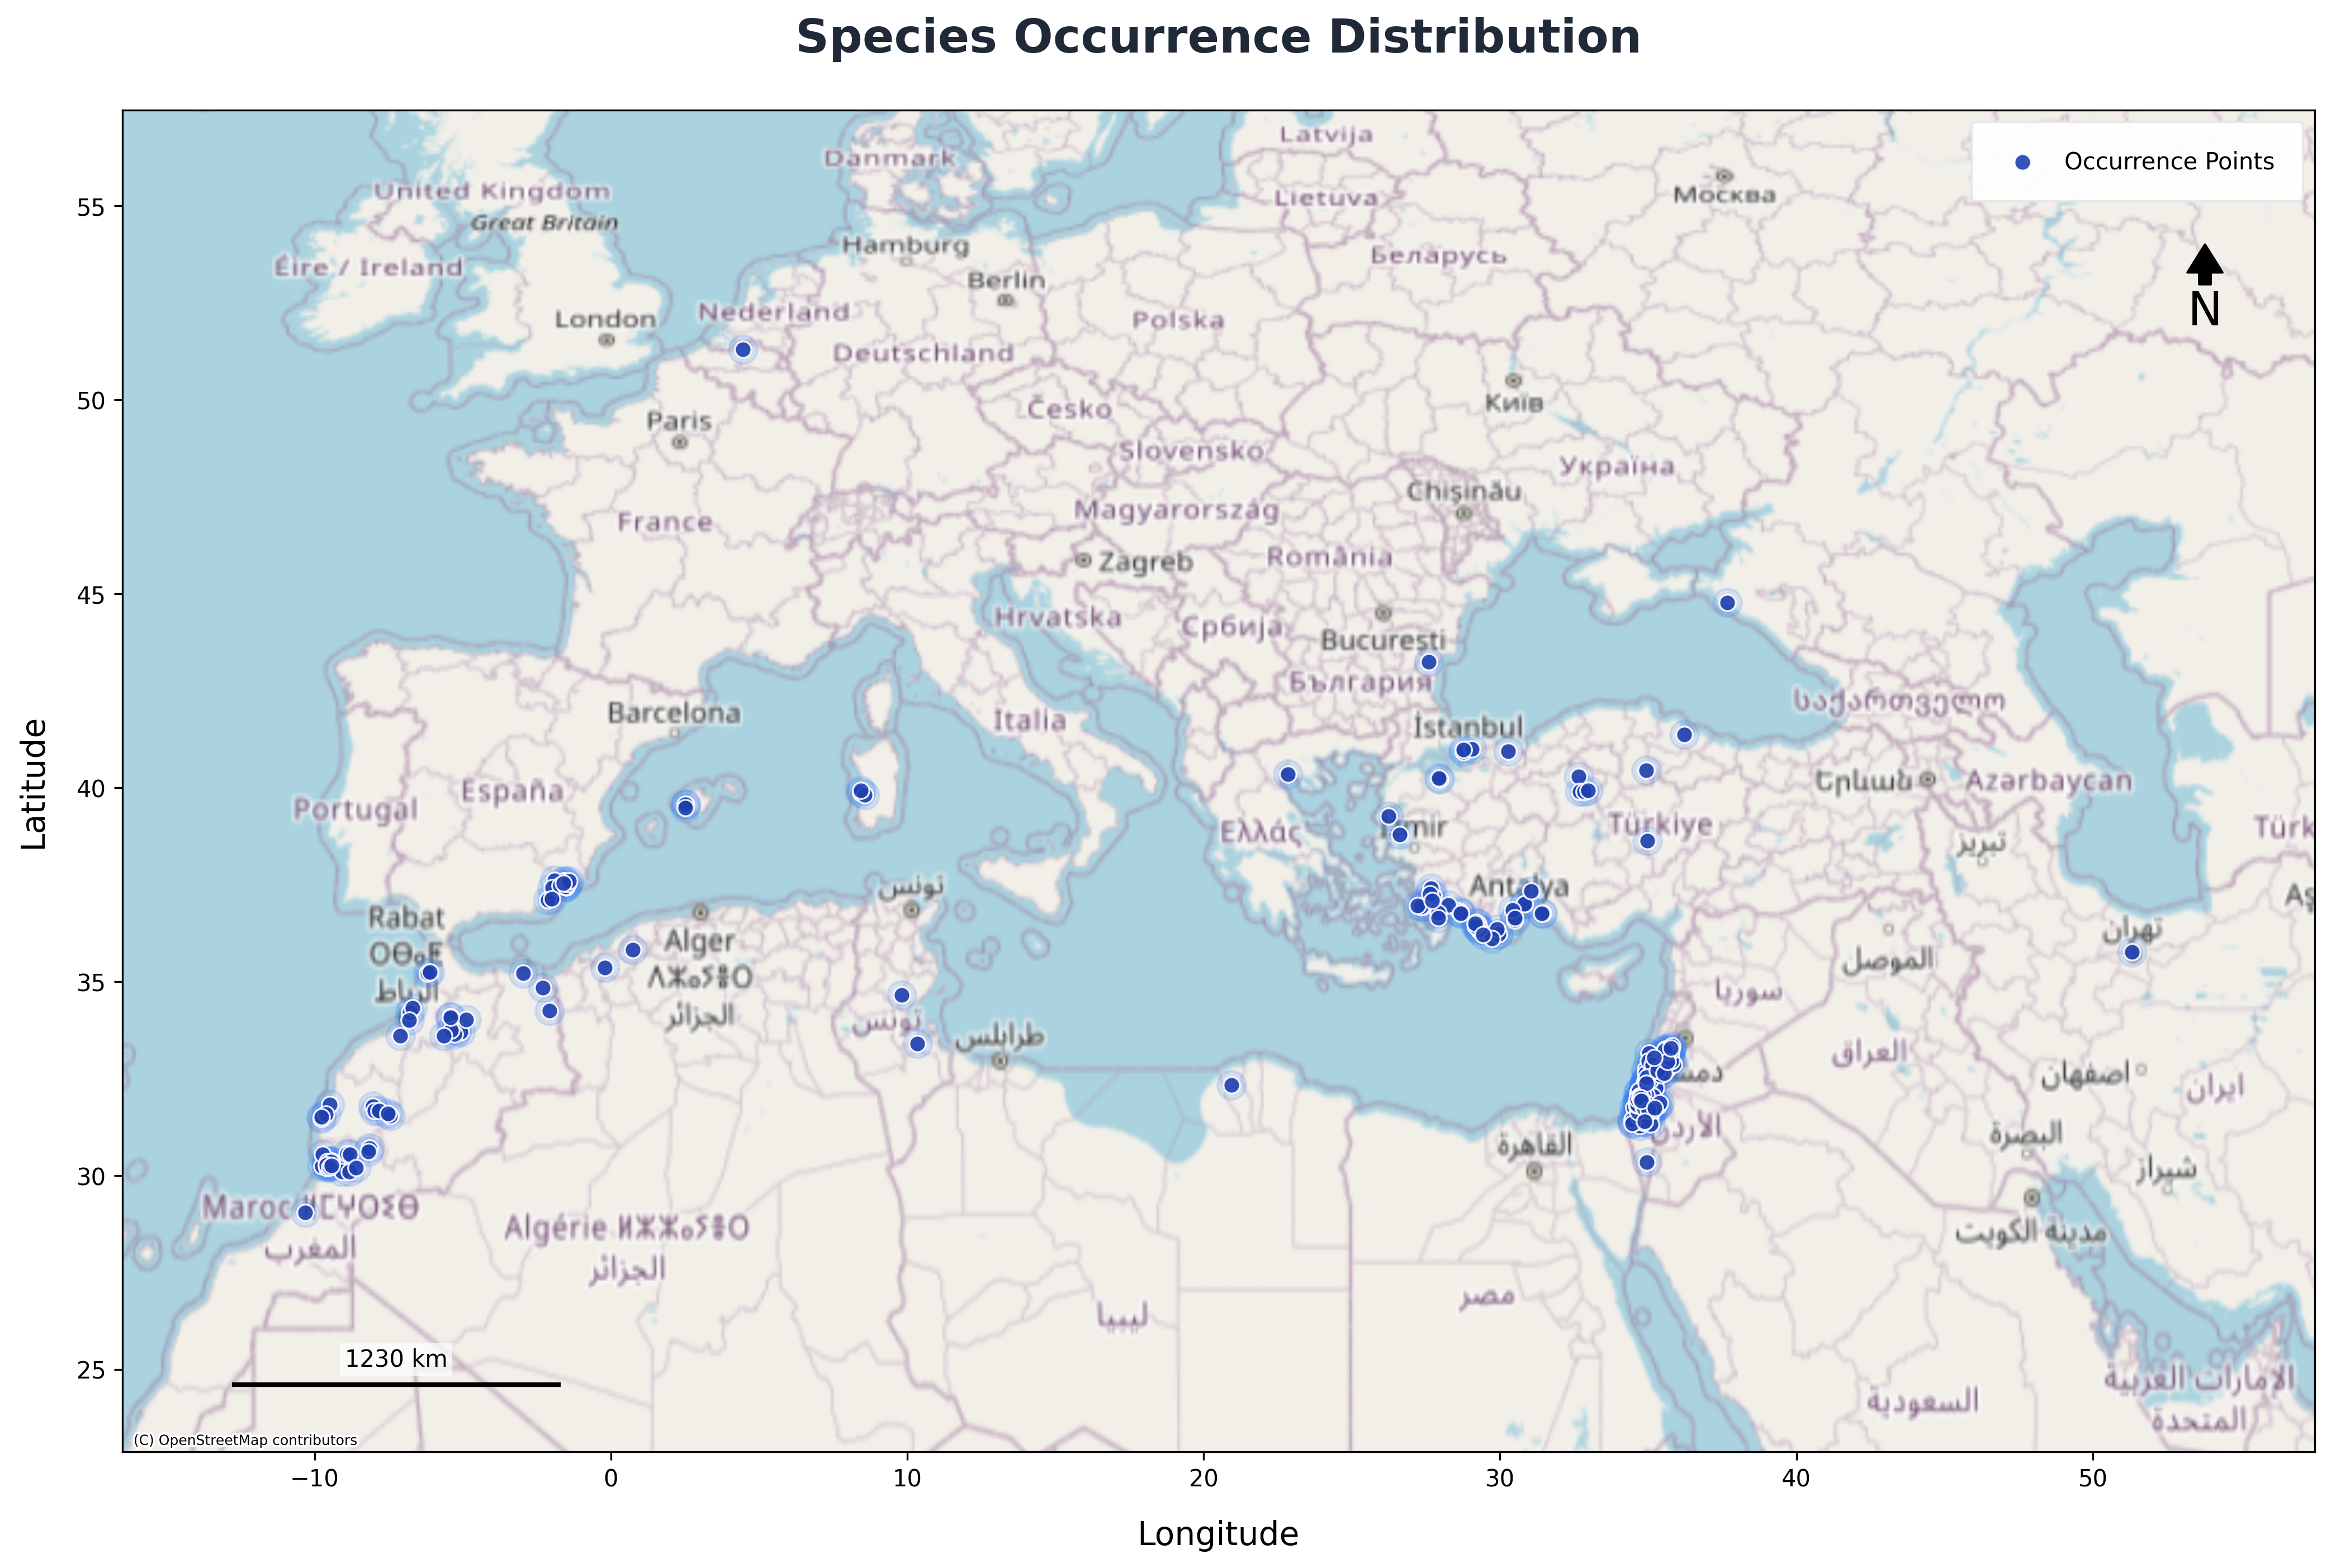

In [47]:
def create_map_with_basemap(occurrence_points, title="Species Occurrence Distribution"):
    """
    Create a map with a real geographic basemap showing species occurrences.
    """
    # Set up the plot
    plt.style.use('default')  # Reset to default style
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': '#f8f9fa',
        'grid.alpha': 0.3,
    })
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot occurrence points first (to determine extent)
    if not occurrence_points.empty:
        # Convert to GeoDataFrame for easier handling
        gdf = gpd.GeoDataFrame(
            occurrence_points,
            geometry=gpd.points_from_xy(
                occurrence_points.decimalLongitude, 
                occurrence_points.decimalLatitude
            ),
            crs="EPSG:4326"  # WGS84
        )
        
        # Plot the points
        scatter = gdf.plot(
            ax=ax,
            color='#1e40af',  # Dark blue
            markersize=50,
            edgecolor='white',
            linewidth=0.8,
            alpha=0.9,
            zorder=5,
            label='Occurrence Points'
        )
        
        # Add glow effect
        gdf.plot(
            ax=ax,
            color='#3b82f6',  # Lighter blue
            markersize=150,
            alpha=0.15,
            zorder=4
        )
        
        # Calculate bounds with some padding
        minx, miny, maxx, maxy = gdf.total_bounds
        padding = max((maxx - minx) * 0.1, (maxy - miny) * 0.1, 0.5)  # At least 0.5 degrees padding
        minx, miny = minx - padding, miny - padding
        maxx, maxy = maxx + padding, maxy + padding
    else:
        # Default bounds if no points
        minx, miny, maxx, maxy = -180, -90, 180, 90
    
    # Set the bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    
    # Add basemap using contextily
    try:
        # Convert to Web Mercator for basemap
        gdf_web_mercator = gdf.to_crs(epsg=3857)
        minx_map, miny_map, maxx_map, maxy_map = gdf_web_mercator.total_bounds
        
        # Add basemap
        ctx.add_basemap(
            ax,
            source=ctx.providers.OpenStreetMap.Mapnik,
            crs='EPSG:4326',
            zoom='auto',
            attribution_size=6
        )
    except Exception as e:
        print(f"Could not load basemap: {e}. Using minimal background.")
        # Fallback: simple background
        ax.set_facecolor('#e8f0f8')
        ax.grid(True, linestyle='--', alpha=0.3, color='#999999')
    
    # Add scale bar
    try:
        from matplotlib_scalebar.scalebar import ScaleBar
        ax.add_artist(ScaleBar(1, location='lower right', border_pad=0.5))
    except:
        # Simple scale line if scalebar not available
        scale_km = (maxx - minx) * 111 * 0.15  # 15% of map width in km
        scale_km = max(1, round(scale_km / 10) * 10)  # Round to nearest 10 km
        scale_deg = scale_km / 111  # Convert km to degrees
        
        scale_x = minx + (maxx - minx) * 0.05
        scale_y = miny + (maxy - miny) * 0.05
        
        ax.plot(
            [scale_x, scale_x + scale_deg],
            [scale_y, scale_y],
            color='black',
            linewidth=2,
            solid_capstyle='butt'
        )
        ax.text(
            scale_x + scale_deg/2,
            scale_y + (maxy - miny) * 0.01,
            f'{scale_km} km',
            ha='center',
            va='bottom',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
        )
    
    # Add north arrow
    arrow_x = maxx - (maxx - minx) * 0.05
    arrow_y = maxy - (maxy - miny) * 0.1
    ax.annotate(
        'N',
        xy=(arrow_x, arrow_y),
        xytext=(arrow_x, arrow_y - (maxy - miny) * 0.05),
        arrowprops=dict(facecolor='black', width=5, headwidth=15),
        ha='center',
        va='center',
        fontsize=20,
        zorder=10
    )
    
    # Add title and labels
    ax.set_title(
        title,
        fontsize=20,
        pad=25,
        fontweight='bold',
        color='#1f2937'
    )
    ax.set_xlabel('Longitude', fontsize=14, labelpad=12)
    ax.set_ylabel('Latitude', fontsize=14, labelpad=12)
    
    # Add legend
    if not occurrence_points.empty:
        ax.legend(
            loc='upper right',
            frameon=True,
            framealpha=0.95,
            facecolor='white',
            edgecolor='#e5e7eb',
            borderpad=1.2
        )
    
   
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for footer
    
    return fig, ax

# Display the map
print("Creating map with geographic basemap...")
fig, ax = create_map_with_basemap(occurrences)

# Save the figure
output_path = 'outputs/geographic_occurrence_map.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

# Display the saved image
from IPython.display import Image, display
display(Image(filename=output_path))

Creating demographic plot...


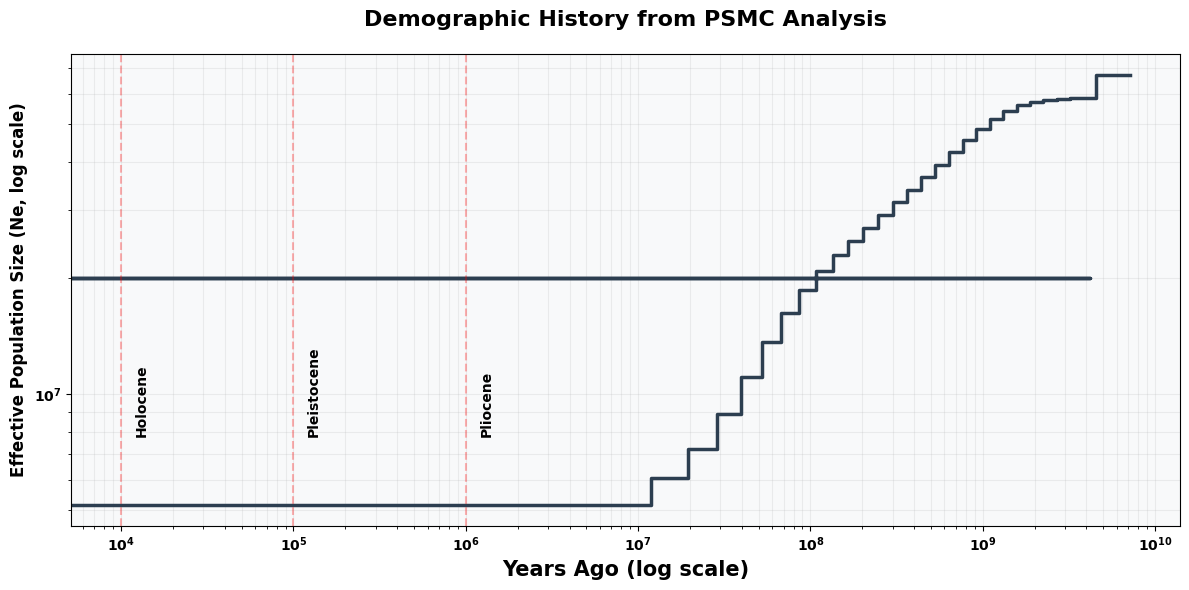

In [59]:
def parse_psmc_file(psmc_file):
    """
    Parse PSMC result file and return time intervals and population sizes
    """
    # Read the PSMC file
    with open(psmc_file, 'r') as f:
        lines = f.readlines()
    
    # Lists to store data
    time_intervals = []
    lambdas = []
    
    # Parse the file line by line
    for line in lines:
        if line.startswith('RS'):
            parts = line.strip().split()
            if len(parts) >= 4:  # Ensure we have enough values
                time_intervals.append(float(parts[2]))  # t_k
                lambdas.append(float(parts[3]))        # lambda_k
    
    # Create a DataFrame
    data = pd.DataFrame({
        't_k': time_intervals,
        'lambda_k': lambdas
    })
    
    return data

def create_demographic_plot(psmc_file, generation_time=7, mu=2.5e-8):
    """
    Create a demographic history plot from PSMC results
    """
    # Parse PSMC data
    data = parse_psmc_file(psmc_file)
    
    if data.empty:
        print("No valid PSMC data found in the file.")
        return None
    
    # Convert time to years and calculate Ne
    data['YearsAgo'] = (data['t_k'] * generation_time) / mu
    data['Ne'] = data['lambda_k'] / (2 * mu)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Use step plot for PSMC
    plt.step(data['YearsAgo'], data['Ne'], 
             where='post', 
             linewidth=2.5, 
             color='#2c3e50')
    
    # Add labels and title
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Years Ago (log scale)', fontsize=15)
    plt.ylabel('Effective Population Size (Ne, log scale)', fontsize=12)
    plt.title('Demographic History from PSMC Analysis', fontsize=16, pad=20)
    
    # Add grid
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    # Add time period annotations
    plt.axvline(x=10000, color='r', linestyle='--', alpha=0.3)
    plt.text(12000, data['Ne'].min()*1.5, 'Holocene', rotation=90, va='bottom', fontsize=10)
    
    plt.axvline(x=100000, color='r', linestyle='--', alpha=0.3)
    plt.text(120000, data['Ne'].min()*1.5, 'Pleistocene', rotation=90, va='bottom', fontsize=10)
    
    plt.axvline(x=1000000, color='r', linestyle='--', alpha=0.3)
    plt.text(1200000, data['Ne'].min()*1.5, 'Pliocene', rotation=90, va='bottom', fontsize=10)
    
    plt.tight_layout()
    return plt

# Example usage
if __name__ == "__main__":
    try:
        # Create and show demographic plot
        print("Creating demographic plot...")
        psmc_plot = create_demographic_plot('/Users/divyadhole/Capstone-project/outputs/PD_0588.psmc')
        if psmc_plot is not None:
            psmc_plot.show()
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Please check the PSMC file format and try again.")